In [207]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Input, Flatten, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, Sequential
from keras.layers.merge import concatenate
from keras.utils import plot_model, to_categorical
from keras.datasets import cifar10

In [208]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Tidak ada GPU yang terdeteksi. Pastikan Anda telah menginstal TensorFlow-GPU.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [209]:
dataset_dir = 'dataset'
all_files = os.listdir(dataset_dir)

train_dir = 'new_dataset/training'
val_dir = 'new_dataset/validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [210]:
class_names = []
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        class_names.append(folder)

# print(class_names)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

print(class_names_label)

IMG_SIZE = (32,32)

{'2017051001': 0, '2017051017': 1, '2117051009': 2, '2117051019': 3, '2117051027': 4, '2117051043': 5, '2117051048': 6, '2117051050': 7, '2117051095': 8, '2157051001': 9, '2157051006': 10}


In [211]:
def load_data():
    DIRECTORY = 'new_dataset'
    CATEGORY = ["training", "validation"]
    
    output = []

    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []

        for folder in os.listdir(path):
            if folder in class_names_label:
                label = class_names_label[folder]

                for file in os.listdir(os.path.join(path, folder)):
                    img_path = os.path.join(os.path.join(path, folder), file)

                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        image = cv2.imread(img_path)

                        if image is not None:
                            image = cv2.resize(image, IMG_SIZE)
                            images.append(image)
                            labels.append(label)

        images = np.array(images, dtype="float32")
        labels = np.array(labels, dtype="int32")

        output.append((images, labels))

    return output

In [212]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [213]:
train_images, train_labels = shuffle(train_images, train_labels, random_state = 25)

In [214]:
def display_examples(class_names, images, labels):
  figsize = (20,20)
  fig = plt.figure(figsize=figsize)
  fig.suptitle("Contoh Sampel Dataset", fontsize=16)
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # image = cv2.resize(images[i], figsize)
    plt.imshow(images[i].astype(np.uint8))
    plt.xlabel(class_names[labels[i]])
  plt.show()

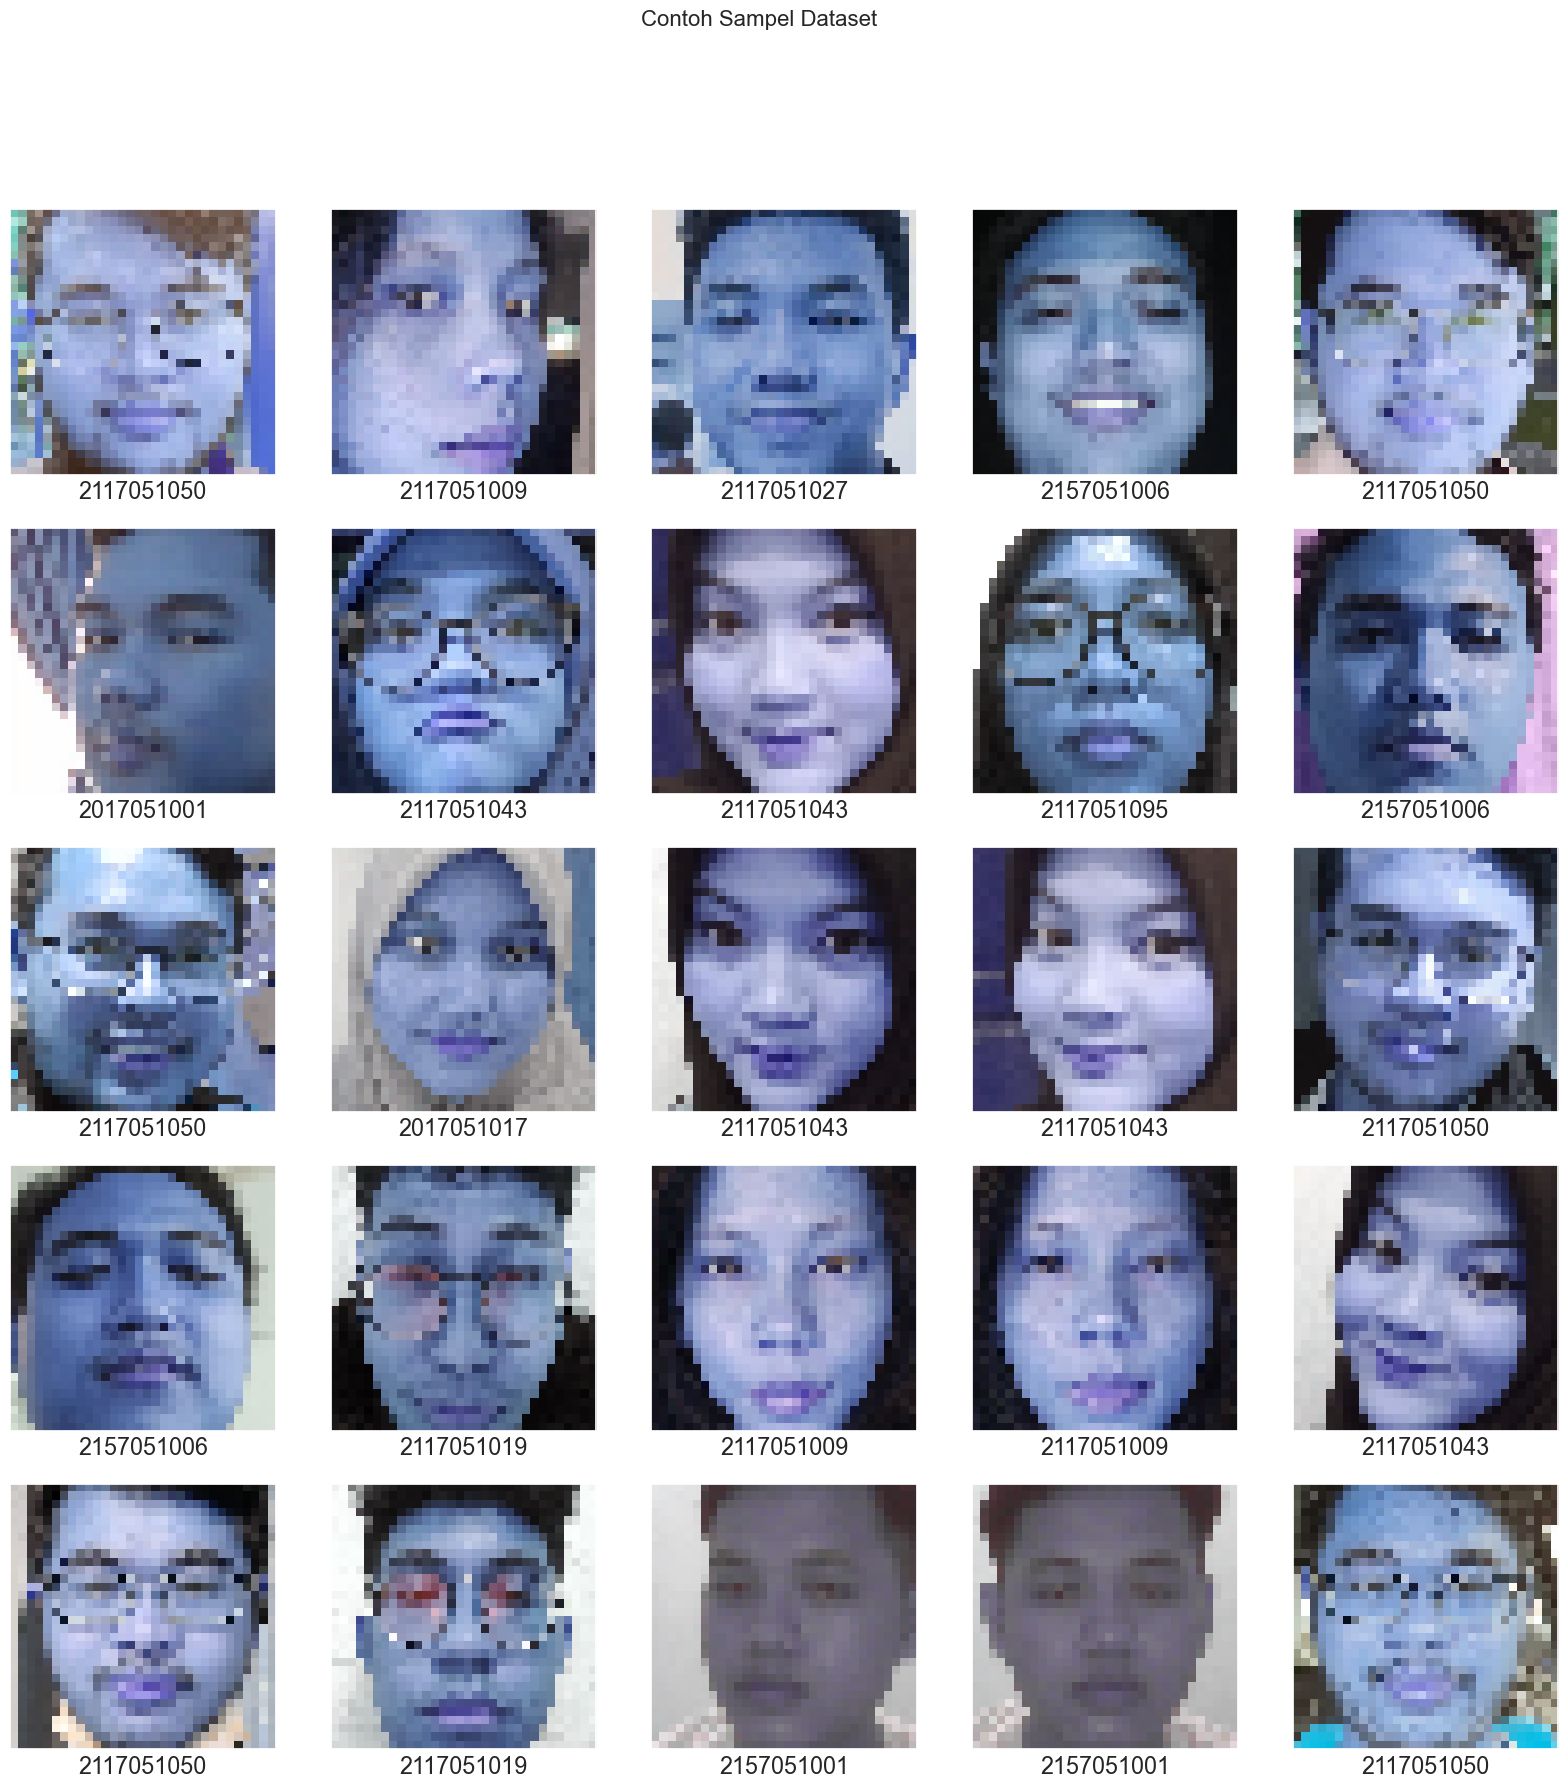

In [215]:
display_examples(class_names, train_images, train_labels)

In [216]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [217]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=(32, 32),
                                               batch_size=32,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=(32, 32),
                                                         batch_size=32,
                                                         class_mode='sparse')

Found 108 images belonging to 11 classes.
Found 51 images belonging to 11 classes.


In [218]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 32, 32, 96)   384         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_245 (Conv2D)             (None, 32, 32, 16)   64          input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_77 (MaxPooling2D) (None, 32, 32, 3)    0           input_14[0][0]                   
___________________________________________________________________________________________

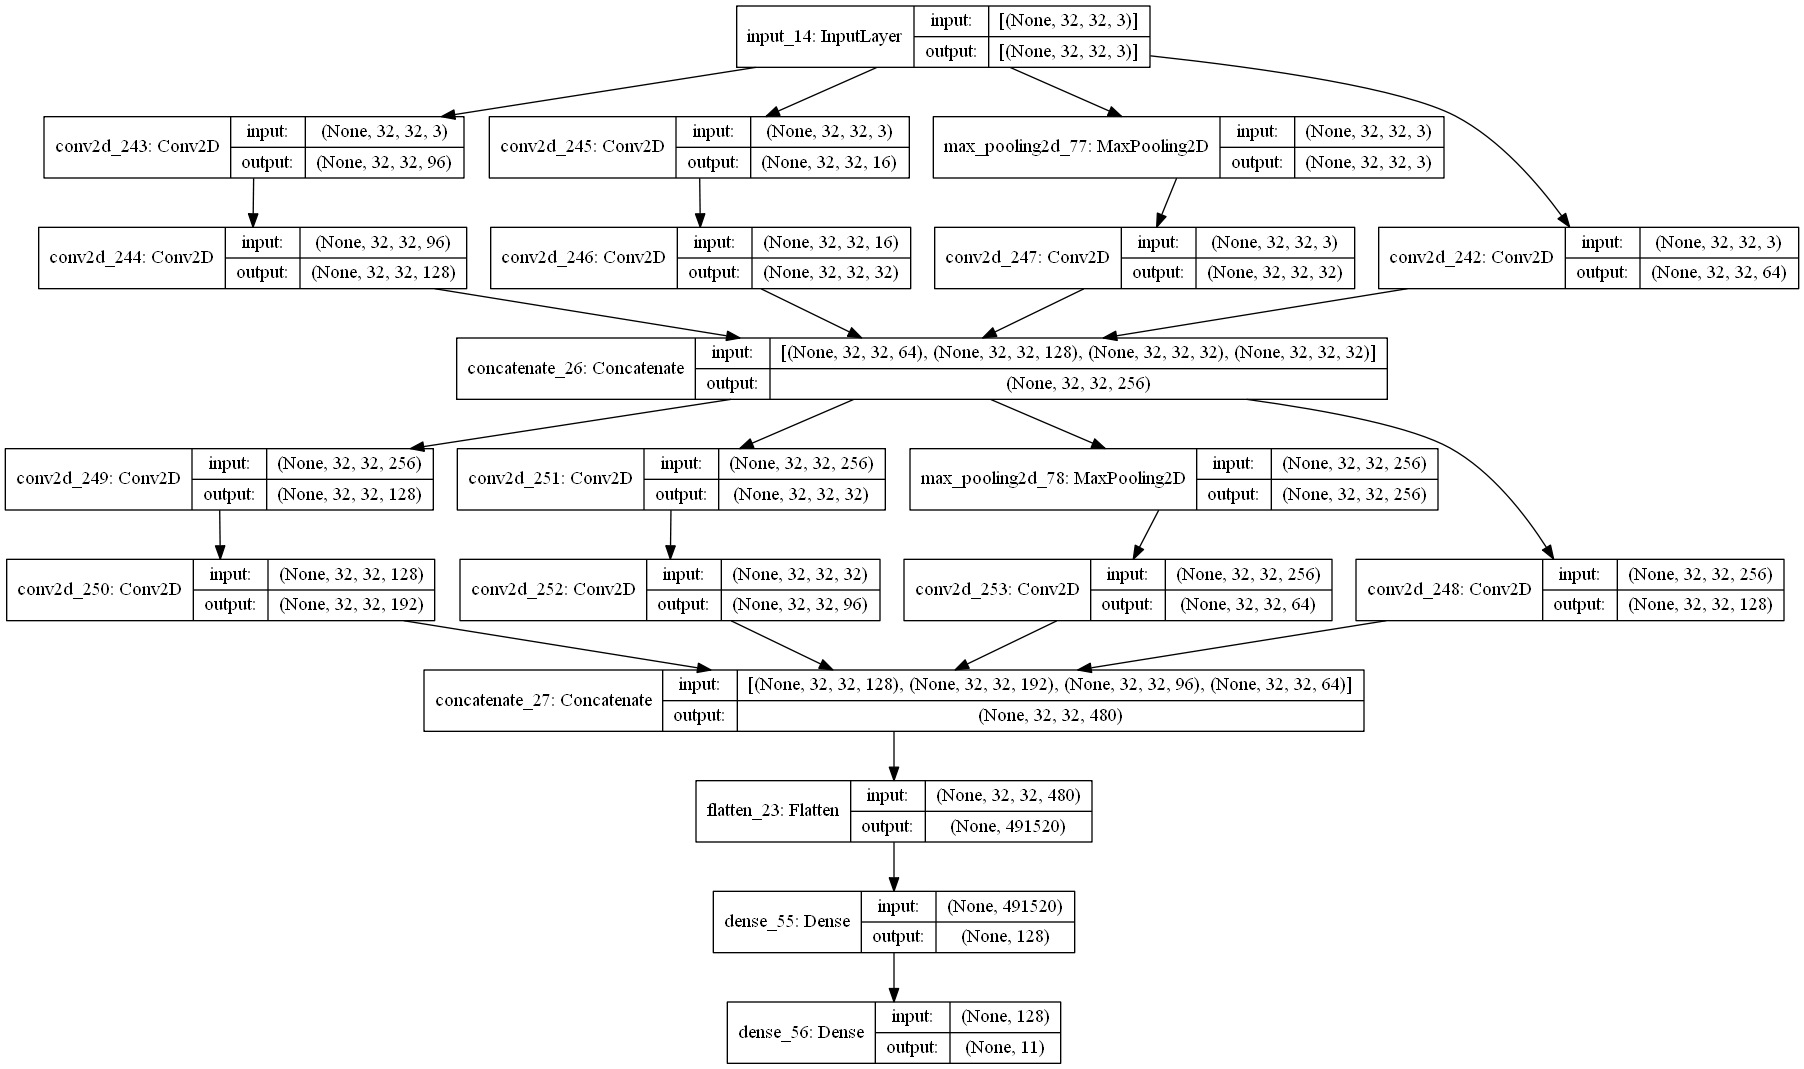

In [219]:
# define model input
visible = Input(shape=(32, 32, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 2
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

# Add Flatten layer to convert the spatial tensor to a vector
layer = Flatten()(layer)

# Add Dense layers for classification
layer = Dense(128, activation='relu')(layer)  # You can change the number of units as needed
output = Dense(train_dataset.num_classes, activation='softmax')(layer)  # nb_classes is the number of classes

# create model
model = Model(inputs=visible, outputs=output)

# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [220]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [221]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=200, validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 37.0475 - accuracy: 0.0814 - val_loss: 3812.5420 - val_accuracy: 0.1818
Epoch 2/200
1/1 [==============================] - 0s 100ms/step - loss: 4524.0078 - accuracy: 0.1047 - val_loss: 5443.3979 - val_accuracy: 0.0455
Epoch 3/200
1/1 [==============================] - 0s 108ms/step - loss: 5365.6831 - accuracy: 0.1163 - val_loss: 3004.1135 - val_accuracy: 0.1818
Epoch 4/200
1/1 [==============================] - 0s 104ms/step - loss: 2915.7539 - accuracy: 0.0930 - val_loss: 1914.1639 - val_accuracy: 0.2273
Epoch 5/200
1/1 [==============================] - 0s 104ms/step - loss: 1671.5342 - accuracy: 0.1977 - val_loss: 1402.8678 - val_accuracy: 0.0909
Epoch 6/200
1/1 [==============================] - 0s 108ms/step - loss: 1074.5570 - accuracy: 0.2558 - val_loss: 1044.5956 - val_accuracy: 0.1364
Epoch 7/200
1/1 [==============================] - 0s 100ms/step - loss: 702.7968 - accuracy: 0.1860 - val_loss: 958.4037 -

In [222]:
def plot_accuracy_loss(history):
  fig = plt.figure(figsize=(10,5))

  plt.subplot(221)
  plt.plot(history.history['accuracy'], 'bo--', label = 'acc')
  plt.plot(history.history['val_accuracy'], 'ro--', label = 'val_acc')
  plt.title("train_acc vs val_acc")
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(222)
  plt.plot(history.history['loss'], 'bo--', label = 'loss')
  plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
  plt.title("train_loss vs val_loss")
  plt.ylabel("loss")
  plt.xlabel("epochs")

  plt.legend()
  plt.show()

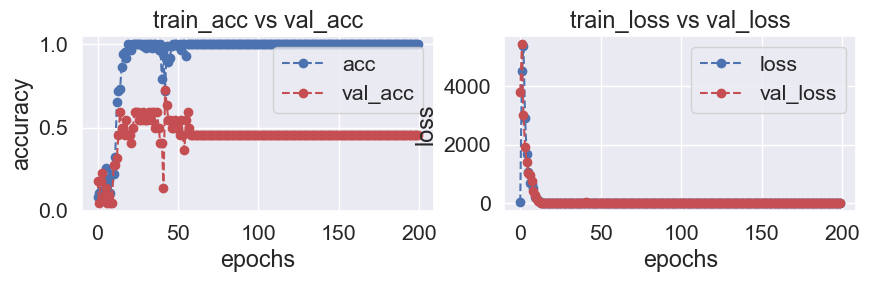

In [223]:
plot_accuracy_loss(history)

In [224]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(128, activation = tf.nn.softmax),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax')
])

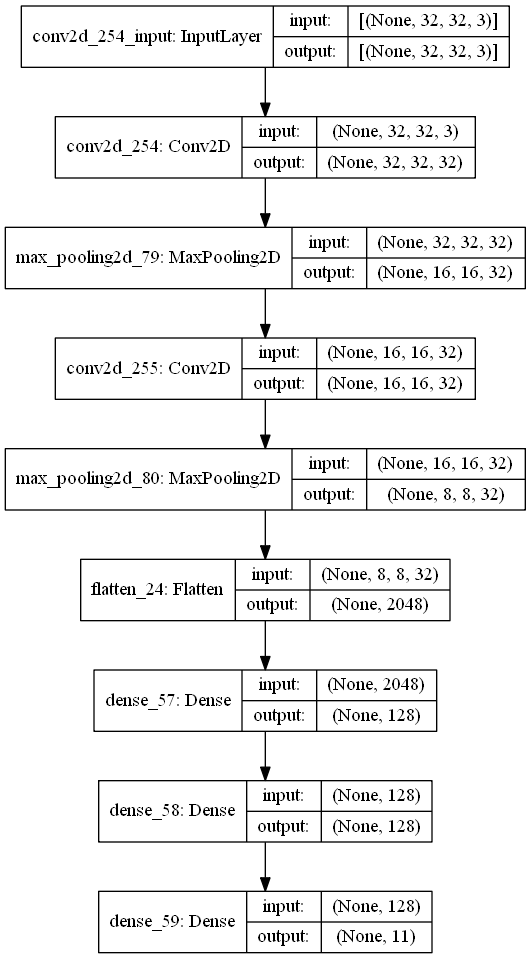

In [225]:
plot_model(model1, show_shapes=True, to_file='inception_module.png')

In [226]:
model1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_254 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_255 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_58 (Dense)             (None, 128)             

In [227]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [228]:
history = model1.fit(train_images, train_labels, batch_size=128, epochs=190, validation_split=0.2)

Epoch 1/190
1/1 [==============================] - 0s 464ms/step - loss: 2.3788 - accuracy: 0.1163 - val_loss: 2.4157 - val_accuracy: 0.0455
Epoch 2/190
1/1 [==============================] - 0s 20ms/step - loss: 2.3952 - accuracy: 0.0698 - val_loss: 2.4154 - val_accuracy: 0.0455
Epoch 3/190
1/1 [==============================] - 0s 20ms/step - loss: 2.3947 - accuracy: 0.0698 - val_loss: 2.4151 - val_accuracy: 0.0455
Epoch 4/190
1/1 [==============================] - 0s 24ms/step - loss: 2.3941 - accuracy: 0.0698 - val_loss: 2.4147 - val_accuracy: 0.0455
Epoch 5/190
1/1 [==============================] - 0s 20ms/step - loss: 2.3935 - accuracy: 0.1512 - val_loss: 2.4143 - val_accuracy: 0.0455
Epoch 6/190
1/1 [==============================] - 0s 20ms/step - loss: 2.3929 - accuracy: 0.1512 - val_loss: 2.4140 - val_accuracy: 0.0455
Epoch 7/190
1/1 [==============================] - 0s 20ms/step - loss: 2.3923 - accuracy: 0.1512 - val_loss: 2.4136 - val_accuracy: 0.0455
Epoch 8/190
1/1 [==

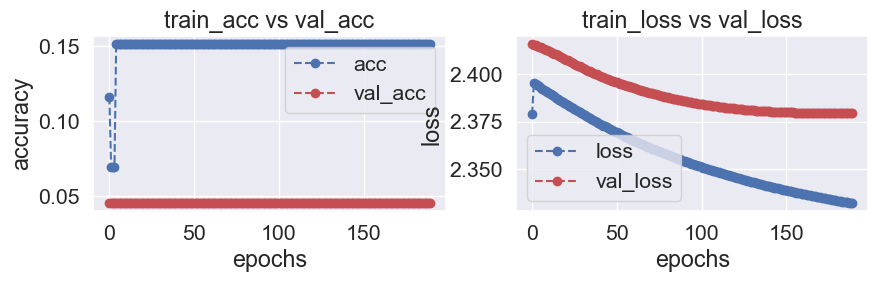

In [229]:
plot_accuracy_loss(history)

In [230]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same'),
    
    tf.keras.layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax')
])

In [231]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [232]:
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=190, validation_split=0.2)

Epoch 1/190
1/1 [==============================] - 1s 808ms/step - loss: 6.8922 - accuracy: 0.0930 - val_loss: 90.9321 - val_accuracy: 0.0455
Epoch 2/190
1/1 [==============================] - 0s 52ms/step - loss: 88.9585 - accuracy: 0.0814 - val_loss: 23.0618 - val_accuracy: 0.0909
Epoch 3/190
1/1 [==============================] - 0s 64ms/step - loss: 23.1329 - accuracy: 0.0698 - val_loss: 6.4034 - val_accuracy: 0.0000e+00
Epoch 4/190
1/1 [==============================] - 0s 67ms/step - loss: 6.9036 - accuracy: 0.0233 - val_loss: 3.3588 - val_accuracy: 0.1364
Epoch 5/190
1/1 [==============================] - 0s 64ms/step - loss: 3.6503 - accuracy: 0.0814 - val_loss: 3.0125 - val_accuracy: 0.1364
Epoch 6/190
1/1 [==============================] - 0s 64ms/step - loss: 2.9792 - accuracy: 0.0930 - val_loss: 2.4021 - val_accuracy: 0.0000e+00
Epoch 7/190
1/1 [==============================] - 0s 64ms/step - loss: 2.3958 - accuracy: 0.1279 - val_loss: 2.3927 - val_accuracy: 0.0455
Epoch 8

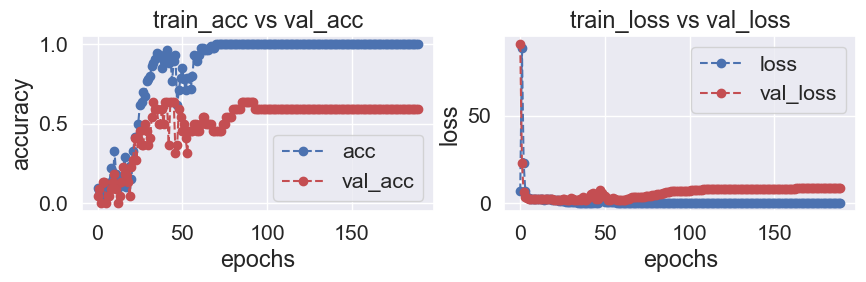

In [233]:
plot_accuracy_loss(history2)

In [234]:
model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_256 (Conv2D)          (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_257 (Conv2D)          (None, 32, 32, 128)       8320      
_________________________________________________________________
conv2d_258 (Conv2D)          (None, 32, 32, 192)       221376    
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_259 (Conv2D)          (None, 32, 32, 32)        6176      
_________________________________________________________________
conv2d_260 (Conv2D)          (None, 32, 32, 128)       4224      
_________________________________________________________________
conv2d_261 (Conv2D)          (None, 32, 32, 192)     